In [ ]:
#Importing the required libraries
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model
import warnings
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [ ]:
# Defining the folder structure
data_dir = 'Audio_dataset'
classes = ['Danger', 'Normal']

In [ ]:
# Load and preprocess audio data
def load_and_preprocess_data(data_dir, classes, target_shape=(256, 256)):
    data = []
    labels = []
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.mp3'):
                file_path = os.path.join(class_dir, filename)
                audio_data, sample_rate = librosa.load(file_path, sr=None)
                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
                mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
                data.append(mel_spectrogram)
                labels.append(i)
    return np.array(data), np.array(labels)

In [ ]:
# Split data into training and testing sets
data, labels = load_and_preprocess_data(data_dir, classes)
labels = to_categorical(labels, num_classes=len(classes))
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
# Model Creation
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)
model = Model(input_layer, output_layer)

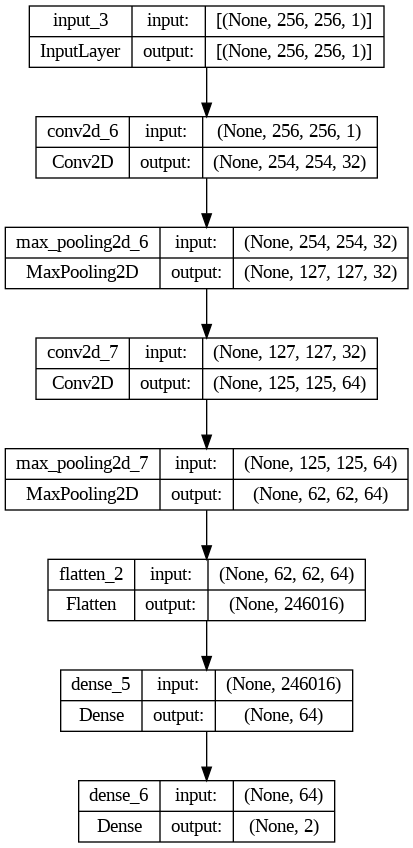

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
10/10 [==============================] - 1s 65ms/step - loss: 0.0920 - accuracy: 0.9743 - val_loss: 2.6973 - val_accuracy: 0.9231
Epoch 2/50
10/10 [==============================] - 1s 53ms/step - loss: 0.1571 - accuracy: 0.9871 - val_loss: 2.4538 - val_accuracy: 0.9359
Epoch 3/50
10/10 [==============================] - 0s 50ms/step - loss: 0.1618 - accuracy: 0.9871 - val_loss: 2.4502 - val_accuracy: 0.9359
Epoch 4/50
10/10 [==============================] - 1s 52ms/step - loss: 0.2665 - accuracy: 0.9743 - val_loss: 3.3734 - val_accuracy: 0.8974
Epoch 5/50
10/10 [==============================] - 0s 50ms/step - loss: 0.3385 - accuracy: 0.9486 - val_loss: 5.6227 - val_accuracy: 0.8718
Epoch 6/50
10/10 [==============================] - 1s 52ms/step - loss: 0.5698 - accuracy: 0.9807 - val_loss: 2.5082 - val_accuracy: 0.8333
Epoch 7/50
10/10 [==============================] - 0s 50ms/step - loss: 0.9216 - accuracy: 0.9453 - val_loss: 5.8880 - val_accuracy: 0.8718
Epoch 8/50
10

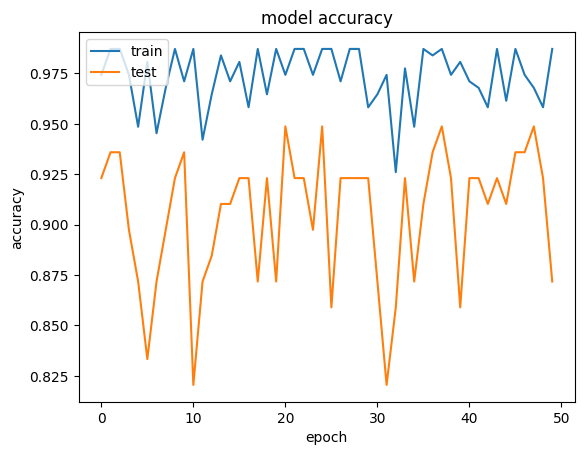

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

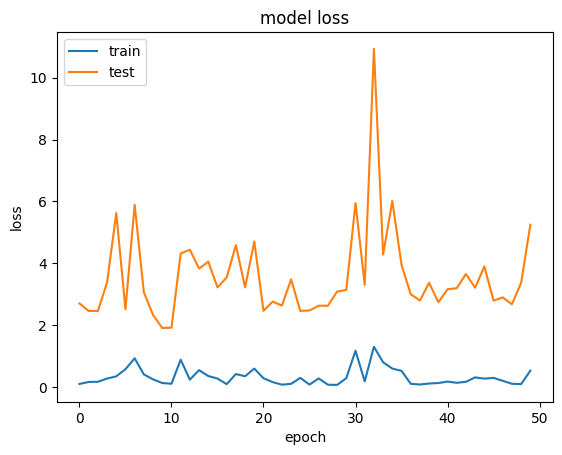

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predicted_test = model.predict(X_test)
predicted_train = model.predict(X_train)
predicted_class = []
for i in range(len(predicted_train)):
  predicted_class.append(np.argmax(predicted_train[i]))
predicted_class_index = []
for i in range(len(predicted_test)):
  predicted_class_index.append(np.argmax(predicted_test[i]))
rounded_test = np.argmax(y_test,axis=1)
rounded_train = np.argmax(y_train,axis=1)

10/10 [==============================] - 0s 16ms/step


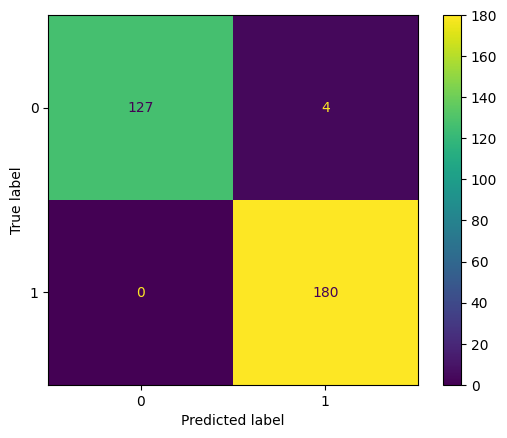

In [ ]:
confusion_matrix = metrics.confusion_matrix(rounded_train, predicted_class)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

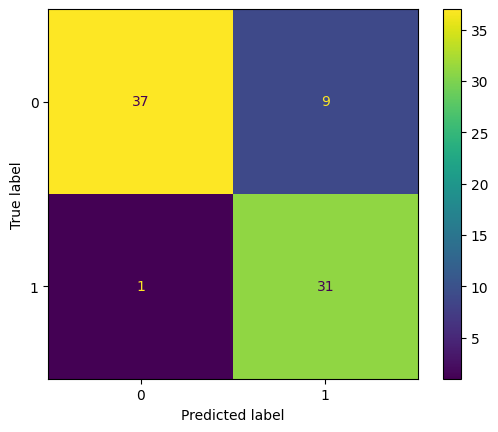

In [ ]:
confusion_matrix = metrics.confusion_matrix(rounded_test, predicted_class_index)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [ ]:
print(classification_report(rounded_test, predicted_class_index))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88        46
           1       0.78      0.97      0.86        32

    accuracy                           0.87        78
   macro avg       0.87      0.89      0.87        78
weighted avg       0.89      0.87      0.87        78



In [ ]:
model.save('audio_classification_model.h5')

In [ ]:
# Load the saved model
model = load_model('audio_classification_model.h5')
# Define the target shape for input spectrograms
target_shape = (256, 256)
# Define your class labels
classes = ['Danger', 'Normal']

In [ ]:
# Function to preprocess and classify an audio file
def test_audio(file_path, model):
    # Load and preprocess the audio file
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
    mel_spectrogram = tf.reshape(mel_spectrogram, (1,) + target_shape + (1,))

    # Make predictions
    predictions = model.predict(mel_spectrogram)

    # Get the class probabilities
    class_probabilities = predictions[0]

    # Get the predicted class index
    predicted_class_index = np.argmax(class_probabilities)

    return class_probabilities, predicted_class_index

In [ ]:
# Test an audio file
test_audio_file = '/content/check_danger9.mp3'
class_probabilities, predicted_class_index = test_audio(test_audio_file, model)

# Display results for all classes
for i, class_label in enumerate(classes):
    probability = class_probabilities[i]
    print(f'Class: {class_label}, Probability: {probability:.4f}')

In [ ]:
# Calculate and display the predicted class and accuracy
predicted_class = classes[predicted_class_index]
accuracy = class_probabilities[predicted_class_index]
print(f'The audio is classified as: {predicted_class}')
print(f'Accuracy: {accuracy:.4f}')

#Second Model

In [ ]:
# Model Creation
input_shape_2 = X_train[0].shape
input_layer_2 = Input(shape=input_shape_2)
x2 = Conv2D(128, (3, 3), activation='relu')(input_layer_2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Conv2D(32, (3, 3), activation='relu')(x2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Conv2D(16, (3, 3), activation='relu')(x2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Conv2D(8, (3, 3), activation='relu')(x2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Flatten()(x2)
x2 = Dense(64, activation='relu')(x2)
x2 = Dense(12, activation='relu')(x2)
output_layer_2 = Dense(len(classes), activation='softmax')(x2)
model2 = Model(input_layer_2, output_layer_2)

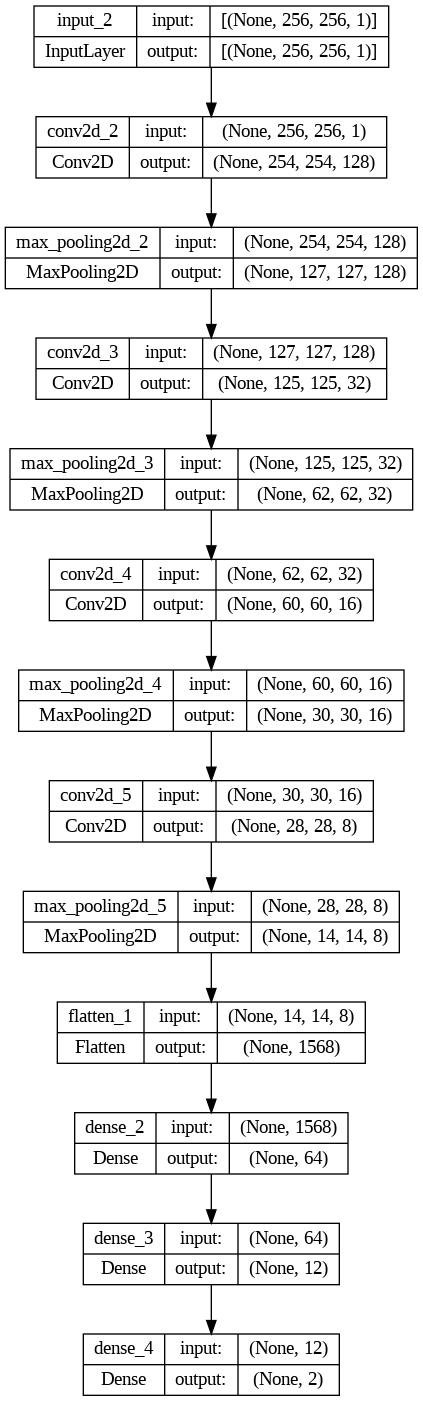

In [ ]:
plot_model(model2, show_shapes=True,to_file='model2.png')

In [ ]:
# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.003), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history2 = model2.fit(X_train, y_train, epochs=22, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/22
10/10 [==============================] - 3s 143ms/step - loss: 25825280.0000 - accuracy: 0.8778 - val_loss: 0.3100 - val_accuracy: 0.8846
Epoch 2/22
10/10 [==============================] - 1s 106ms/step - loss: 0.6558 - accuracy: 0.9325 - val_loss: 1.0701 - val_accuracy: 0.9103
Epoch 3/22
10/10 [==============================] - 1s 115ms/step - loss: 0.6253 - accuracy: 0.9550 - val_loss: 22122602.0000 - val_accuracy: 0.8718
Epoch 4/22
10/10 [==============================] - 1s 105ms/step - loss: 495403584.0000 - accuracy: 0.9518 - val_loss: 0.7274 - val_accuracy: 0.9231
Epoch 5/22
10/10 [==============================] - 1s 105ms/step - loss: 0.4474 - accuracy: 0.9228 - val_loss: 0.4012 - val_accuracy: 0.8718
Epoch 6/22
10/10 [==============================] - 1s 117ms/step - loss: 0.2616 - accuracy: 0.9100 - val_loss: 0.3568 - val_accuracy: 0.8333
Epoch 7/22
10/10 [==============================] - 1s 110ms/step - loss: 0.2008 - accuracy: 0.9100 - val_loss: 0.3243 - val_a

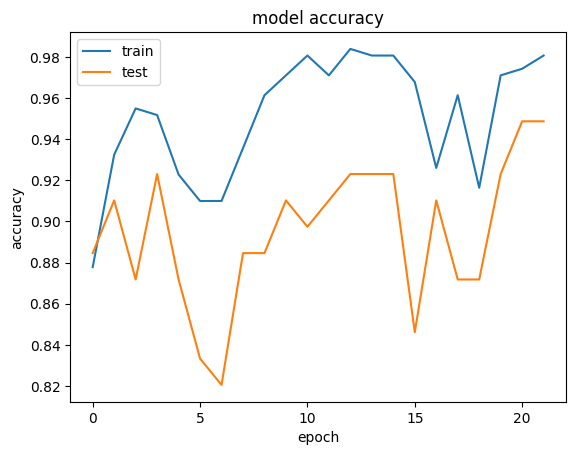

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

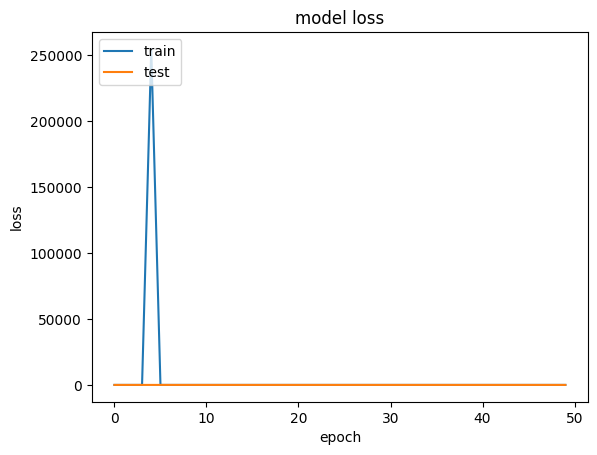

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predicted_test = model2.predict(X_test)
predicted_train = model2.predict(X_train)
predicted_class = []
for i in range(len(predicted_train)):
  predicted_class.append(np.argmax(predicted_train[i]))
predicted_class_index = []
for i in range(len(predicted_test)):
  predicted_class_index.append(np.argmax(predicted_test[i]))
rounded_test = np.argmax(y_test,axis=1)
rounded_train = np.argmax(y_train,axis=1)

10/10 [==============================] - 0s 31ms/step


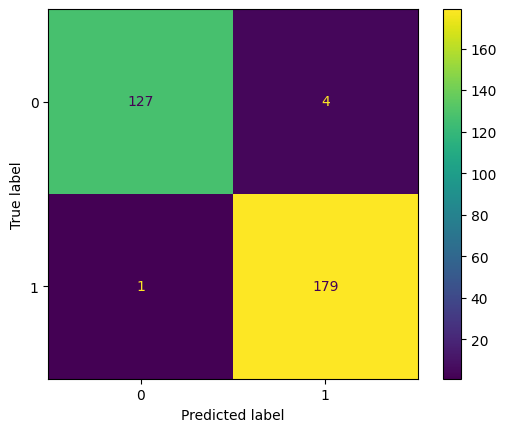

In [ ]:
confusion_matrix = metrics.confusion_matrix(rounded_train, predicted_class)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

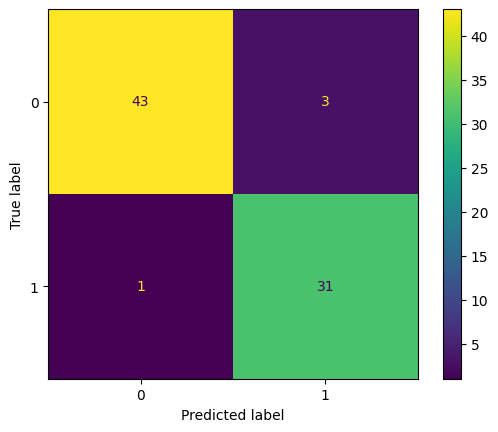

In [ ]:
confusion_matrix = metrics.confusion_matrix(rounded_test, predicted_class_index)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [ ]:
print(classification_report(rounded_test, predicted_class_index))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96        46
           1       0.91      0.97      0.94        32

    accuracy                           0.95        78
   macro avg       0.94      0.95      0.95        78
weighted avg       0.95      0.95      0.95        78

